In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/nurbano/lpc_clustering

Cloning into 'lpc_clustering'...
remote: Enumerating objects: 284, done.
remote: Total 284 (delta 0), reused 0 (delta 0), pack-reused 284
Receiving objects: 100% (284/284), 8.12 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [3]:
import gdown
url = "https://drive.google.com/u/1/uc?id=14QKcFMjWaENQXVo91eFWcmJpI4qAjjyx&export=download"
out_path = "table_4.z01" 
gdown.download(url, out_path, quiet=False)

Downloading...
From: https://drive.google.com/u/1/uc?id=14QKcFMjWaENQXVo91eFWcmJpI4qAjjyx&export=download
To: /content/table_4.z01
100%|██████████| 21.0M/21.0M [00:00<00:00, 23.5MB/s]


'table_4.z01'

In [4]:
url = "https://drive.google.com/u/1/uc?id=1gfL8MLxTGOT2smXOe0lywGFAR3zm1mEr&export=download"
out_path = "table_4.zip" 
gdown.download(url, out_path, quiet=False)

Downloading...
From: https://drive.google.com/u/1/uc?id=1gfL8MLxTGOT2smXOe0lywGFAR3zm1mEr&export=download
To: /content/table_4.zip
100%|██████████| 12.3M/12.3M [00:00<00:00, 27.2MB/s]


'table_4.zip'

In [6]:
!zip -F table_4.zip --out table.zip


Fix archive (-F) - assume mostly intact archive
 copying: 2021_heerlen_table.las


In [7]:
!unzip table.zip

Archive:  table.zip
  inflating: 2021_heerlen_table.las  


In [8]:
path="./lpc_clustering/"
aviones= "aviones.xyz"
autos= "autos.xyz"
table= "./2021_heerlen_table.las"

## Dataset

In [9]:
!pip install laspy #Instalo la librería laspy
import laspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for laspy: filename=laspy-2.4.1-py3-none-any.whl size=68061 sha256=fc3e62bd2b717408ccd6a15e914f0bbafdddadfe977048e43d617298fc567814
  Stored in directory: /root/.cache/pip/wheels/b7/84/b9/28a55f13245e29f4bee5274790ace34180da34cf230679fcf3
Successfully built laspy


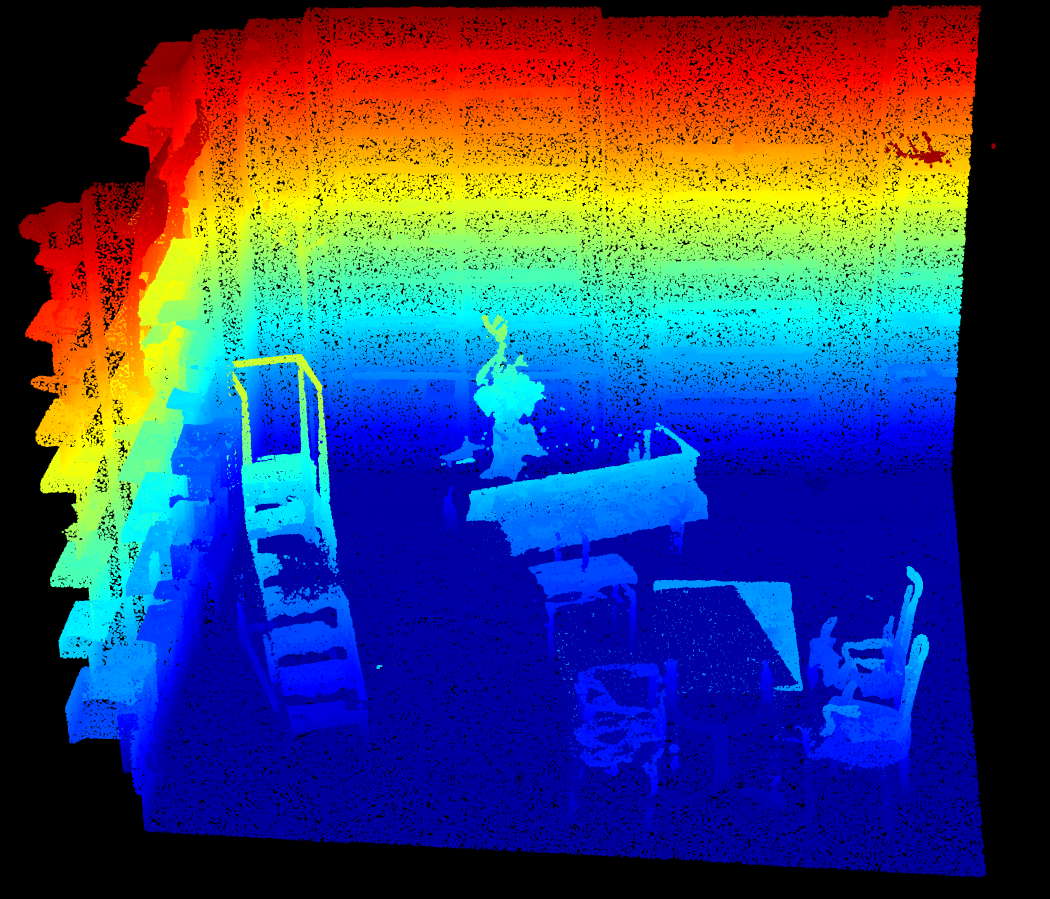

In [10]:
# x,y,z,ilum,refle,inte,nb= np.loadtxt(path+aviones,skiprows=1, delimiter=";", unpack=True)
# x,y,z,ilum,refle,inte= np.loadtxt(path+escritorio,skiprows=1, unpack=True)
# x,y,z,ilum,refle,inte= np.loadtxt(path+autos,skiprows=1, delimiter=";",unpack=True)
# x,y,z,ilum,inte= np.loadtxt(path+adas,skiprows=1,unpack=True)
# x,y,z,ilum,refle,inte,nb, nb2, nb3= np.loadtxt(table, skiprows=1, unpack=True)


Cargo el dataset que se encuentra en un archivo con extensión las, a partir de la librería laspy.

In [11]:
with laspy.open(table) as fh:
    print('Points from Header:', fh.header.point_count)
    las = fh.read()
    print(las)
    print('Points from data:', len(las.points))
    ground_pts = las.classification == 2
    bins, counts = np.unique(las.return_number[ground_pts], return_counts=True)
    print('Ground Point Return Number distribution:')
    for r,c in zip(bins,counts):
        print('    {}:{}'.format(r,c))


Points from Header: 4119666
<LasData(1.4, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 4119666 points, 0 vlrs)>
Points from data: 4119666
Ground Point Return Number distribution:


In [12]:
point_format = las.point_format

Listo las variables que tiene el dataset.
En este caso vamos a usar las coordenadas de los puntos, y la intensidad de la señal lidar:

*   X
*   Y
*   Z
*   intensity



In [13]:
list(point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

Escalo las coordenadas x,y, z

In [14]:
def scaled_x_dimension(las_file):
    x_dimension = las_file.X
    scale = las_file.header.scales[0]
    offset = las_file.header.offsets[0]
    return (x_dimension * scale) + offset

scaled_x = scaled_x_dimension(las)

In [15]:
def scaled_z_dimension(las_file):
    z_dimension = las_file.Z
    scale = las_file.header.scales[0]
    offset = las_file.header.offsets[0]
    return (z_dimension * scale) + offset

scaled_z = scaled_z_dimension(las)

In [16]:
def scaled_y_dimension(las_file):
    y_dimension = las_file.Y
    scale = las_file.header.scales[0]
    offset = las_file.header.offsets[0]
    return (y_dimension * scale) + offset

scaled_y = scaled_y_dimension(las)

In [17]:
inten= np.array(las.intensity)

Cargo las coordenas cartesianas como un array de numpy

In [18]:
x= np.array(scaled_x)
y= np.array(scaled_y)
z= np.array(scaled_z)

#Preprocesamiento
Se crean diferentes máscaras,
La primera para filtrar el piso.
La segunda, para recortar sólo el espacio de la mesa y la silla.
Además, se filtran las paredes laterales, la escalera, y la maceta.

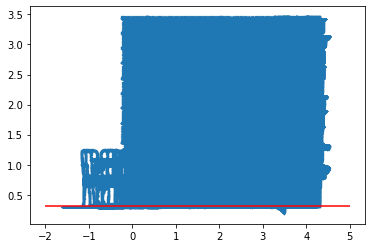

In [19]:
piso= 0.32
plt.scatter(y,z, s=0.01)
plt.hlines(piso, -2, 5, color='r')

In [20]:
nube=np.column_stack((x,y,z))
mascara= (z>piso) & (z<1.5) & (y<1) & (x>-2.5)
nube_filtrada= nube[z>2]

mascara_piso= z>piso #Se filtra por coordenada z el piso

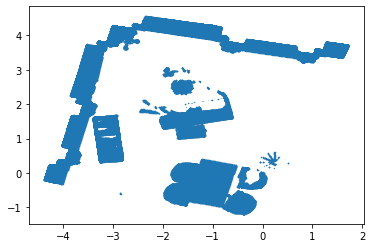

In [21]:
plt.scatter(x[mascara_piso],y[mascara_piso], s=0.01) 


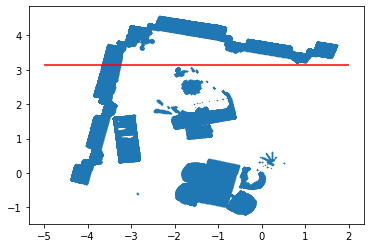

In [22]:
pared_trasera= 3.15
plt.scatter(x[mascara_piso],y[mascara_piso], s=0.01)
plt.hlines(pared_trasera, -5, 2, color='r')

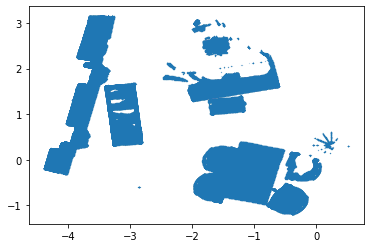

In [23]:
mascara_pared_piso= (z>piso) & (y<pared_trasera)
plt.scatter(x[mascara_pared_piso],y[mascara_pared_piso], s=0.01)


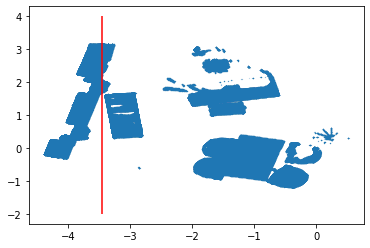

In [24]:
pared_lateral= -3.45
plt.scatter(x[mascara_pared_piso],y[mascara_pared_piso], s=0.01)
plt.vlines(pared_lateral, -2, 4, color='r')

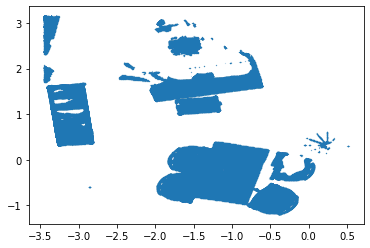

In [25]:
mascara_pared_piso_2= (z>piso) & (y<pared_trasera) & (x>pared_lateral)
plt.scatter(x[mascara_pared_piso_2],y[mascara_pared_piso_2], s=0.01)


In [26]:
mascara_escalera= (z<2.5) & (y<2) & (y>0) & (x>-3.5) & (x<-2.5)
mascara_maceta= (z>0.35) & (z<2.5) & (y<3.1) & (y>1) & (x>-2.5) & (x<0)


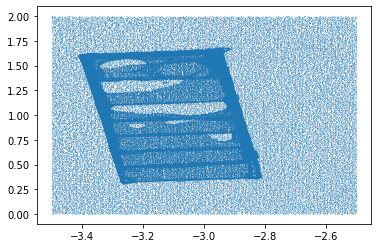

In [27]:
plt.scatter(x[mascara_escalera],y[mascara_escalera], s=0.01) 


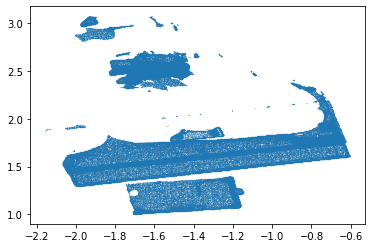

In [28]:
plt.scatter(x[mascara_maceta],y[mascara_maceta], s=0.01) 


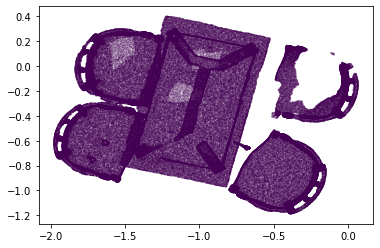

In [29]:
plt.scatter(x[mascara],y[mascara], c=inten[mascara],s=0.01)

In [34]:
#Se almacena la mesa en un archivo .las aparte.
new_las = laspy.LasData(las.header)
points_kept = las.points[mascara]
new_las.points= points_kept.copy()
new_las.write("mesa.las")



In [33]:
#Se almacena la escalera en un archivo .las aparte.

new_las = laspy.LasData(las.header)
points_kept = las.points[mascara_escalera]
new_las.points= points_kept.copy()
new_las.write("escalera.las")


In [32]:
#Se almacena la maceta en un archivo .las aparte.

new_las = laspy.LasData(las.header)
points_kept = las.points[mascara_maceta]
new_las.points= points_kept.copy()
new_las.write("maceta.las")


Se grafica el dataset en 3 dimensiones

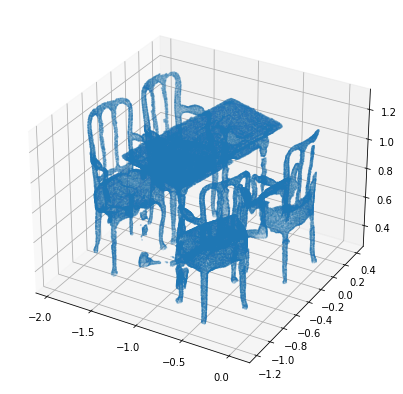

In [35]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
ax.scatter(x[mascara],y[mascara],z[mascara], s=0.01)


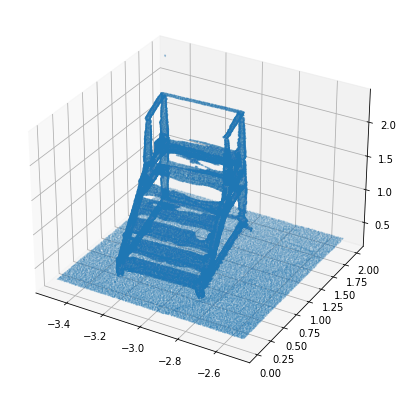

In [36]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
ax.scatter(x[mascara_escalera],y[mascara_escalera],z[mascara_escalera], s=0.01)

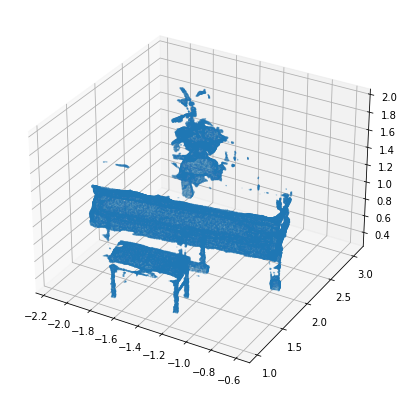

In [37]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
ax.scatter(x[mascara_maceta],y[mascara_maceta],z[mascara_maceta], s=0.01)

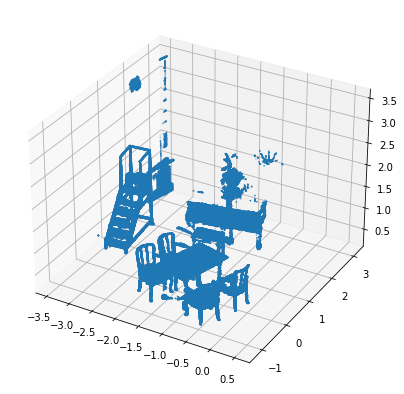

In [38]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
ax.scatter(x[mascara_pared_piso_2],y[mascara_pared_piso_2],z[mascara_pared_piso_2], s=0.01)

Se define una función graficar para facilitar la visualización de los datos. En la misma se visualiza el plano XY, el plano XZ, y la vista en 3 dimensiones.

In [39]:
S= 0.01
# S= 0.1
# S= 1
def graficar(x,y,z,inte):

  fig = plt.figure(figsize=(15,5))

  ax = fig.add_subplot(1,3,1)
  ax.scatter(x,y, s=S ,c=inte)
  ax.set_title("Vista X e Y")
  ax.set_xlabel("X")
  ax.set_ylabel("Y")

  ax = fig.add_subplot(1,3,2)
  ax.scatter(x,z, s=S, c=inte)
  ax.set_title("Vista X y Z")
  ax.set_xlabel("X")
  ax.set_ylabel("Z")

  ax = fig.add_subplot(1,3,3, projection='3d')
  ax.scatter(x,y,z, s=S, c=inte)
  ax.set_title("Vista 3D")

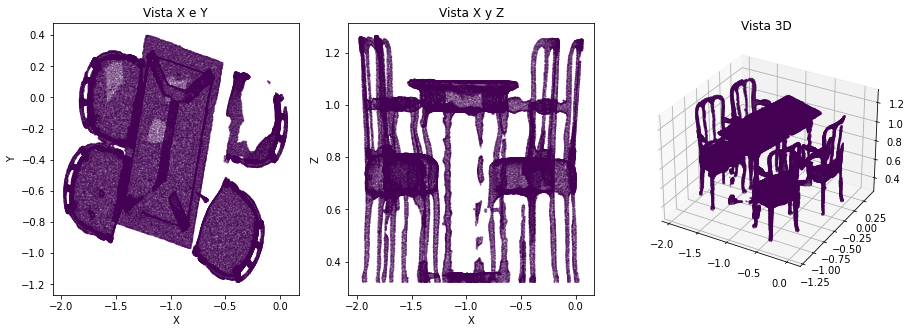

In [40]:
graficar(x[mascara],y[mascara],z[mascara], inten[mascara])


In [41]:
#Se define una función, para reducir la cantidad de puntos forma aleatoria
#, y de eso modo, realizar un procesamiento de los algoritmos de clustering más rápido
def filtro_aleatorio(X_in, porc): 

  N = int(len(X_in)*porc/100)
  idx = np.random.choice(np.arange(X_in.shape[0]), size=N)

  return X[idx]

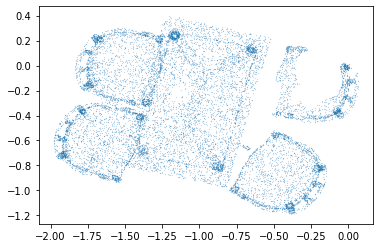

In [44]:
#Se grafica la mesa, con un 5% de los puntos del dataset
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
X_filtrada= filtro_aleatorio(X, 5)
plt.scatter(X_filtrada[:, 0], X_filtrada[:,1], s= 0.01)

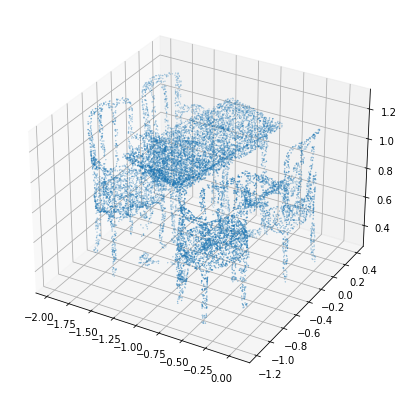

In [45]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
ax.scatter(X_filtrada[:, 0], X_filtrada[:,1], X_filtrada[:,2], s=0.1)

# Clustering

## K-means
Se utiliza:

1. Mesa -> k=5, ya que son 5 objetos, 4 sillas y la mesa.

2. Escalera -> k=2 se intenta agrupar al piso y a la escalera. Además se evalua con 2 algortimos "elkan" y "lloyd" que es el algortimo por defecto de sklearn.
3. Maceta -> k=3. También se evaluan los 2 algortimos.




In [46]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


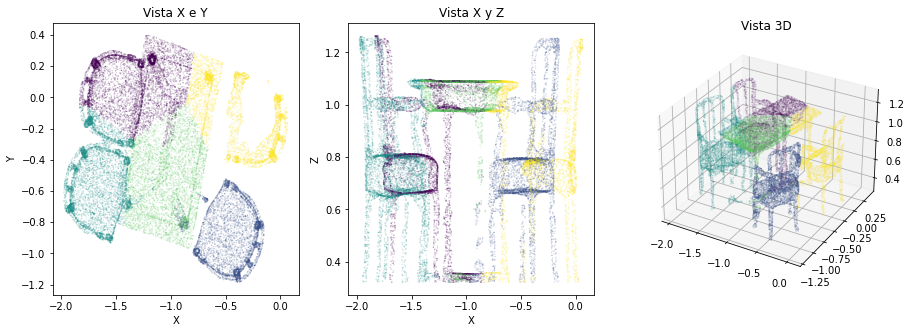

In [47]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
X_filtrada= filtro_aleatorio(X, 10)

kmeans = KMeans(n_clusters=5).fit(X_filtrada)
clase_pred=kmeans.labels_
graficar(X_filtrada[:, 0], X_filtrada[:,1], X_filtrada[:,2], clase_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


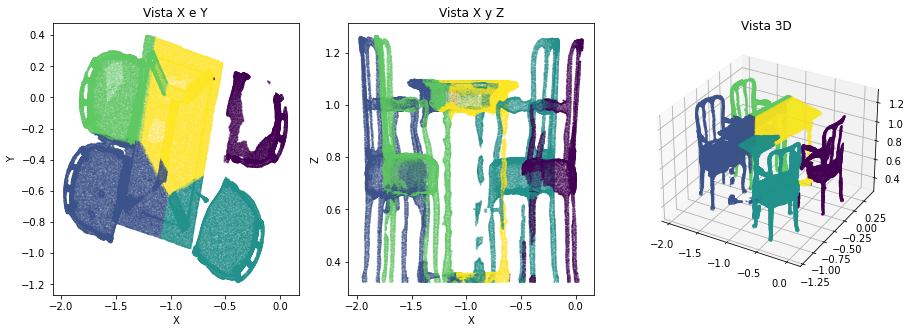

In [48]:
 X=np.column_stack((x[mascara], y[mascara], z[mascara]))
kmeans = KMeans(n_clusters=5, algorithm= 'elkan').fit(X)
clase_pred=kmeans.labels_
graficar(x[mascara],y[mascara],z[mascara], clase_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


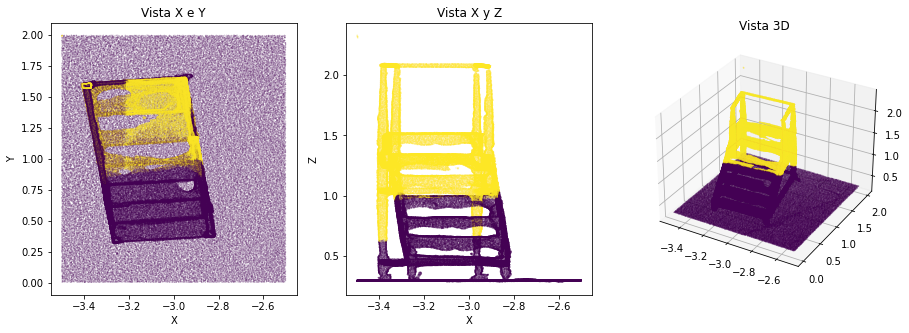

In [49]:
X=np.column_stack((x[mascara_escalera], y[mascara_escalera], z[mascara_escalera]))
kmeans = KMeans(n_clusters=2).fit(X)
clase_pred=kmeans.labels_
graficar(x[mascara_escalera],y[mascara_escalera],z[mascara_escalera], clase_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


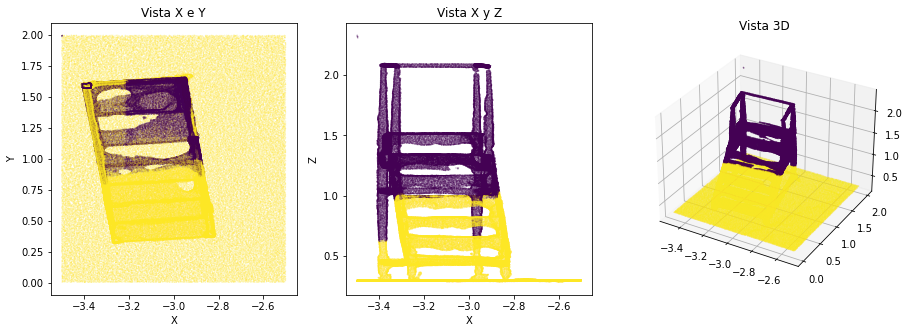

In [50]:
X=np.column_stack((x[mascara_escalera], y[mascara_escalera], z[mascara_escalera]))
kmeans = KMeans(n_clusters=2, algorithm= 'elkan').fit(X)
clase_pred=kmeans.labels_
graficar(x[mascara_escalera],y[mascara_escalera],z[mascara_escalera], clase_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


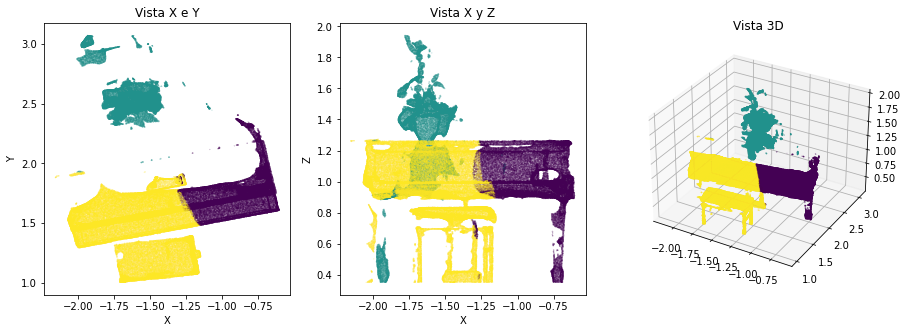

In [51]:
X=np.column_stack((x[mascara_maceta], y[mascara_maceta], z[mascara_maceta]))
kmeans = KMeans(n_clusters=3).fit(X)
clase_pred=kmeans.labels_
graficar(x[mascara_maceta],y[mascara_maceta],z[mascara_maceta], clase_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


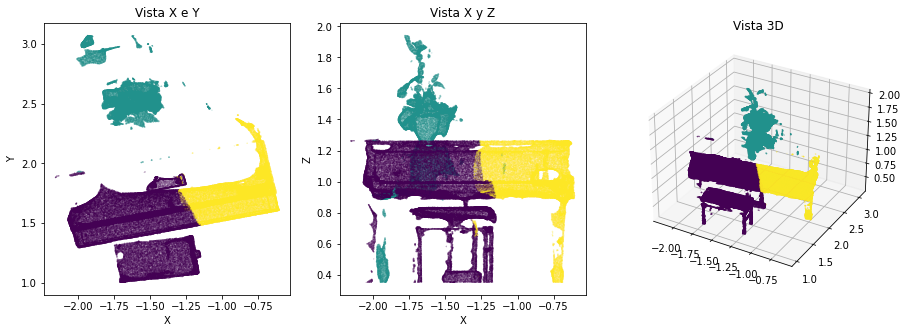

In [52]:
X=np.column_stack((x[mascara_maceta], y[mascara_maceta], z[mascara_maceta]))
kmeans = KMeans(n_clusters=3, algorithm= 'elkan').fit(X)
clase_pred=kmeans.labels_
graficar(x[mascara_maceta],y[mascara_maceta],z[mascara_maceta], clase_pred)

## minibatch K-means

Se evalua K-means sólo para la mesa. con k=5, se obtienen resultados similares a k-means.

In [53]:
from sklearn.cluster import MiniBatchKMeans

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


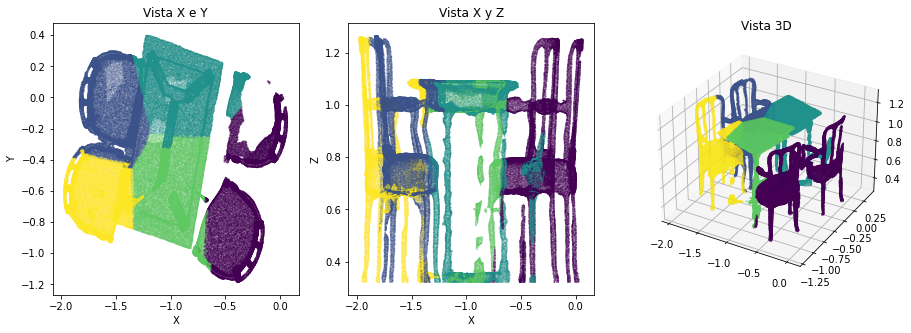

In [54]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
kmeans = MiniBatchKMeans(n_clusters=5).fit(X)
clase_pred=kmeans.labels_
graficar(x[mascara],y[mascara],z[mascara], clase_pred)

## DB-SCAN

Se evalua los resultados con DB-SCAN.
Se utiliza un eps de 0.1. En el caso del dataset de la mesa, para valores de eps superiores a 0.1, se utiliza mucha memoria RAM, y el colab se reinicia.
En cada caso, se imprime la cantidad de cluster detectados.

In [55]:
from sklearn.cluster import DBSCAN

Cantidad de Cluster: 
5


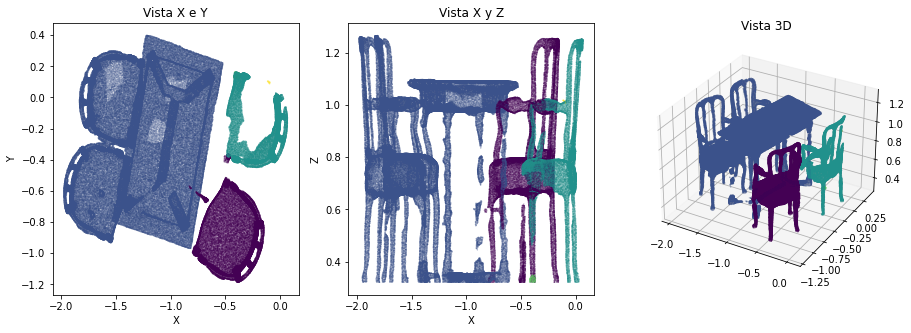

In [59]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
cluster_db = DBSCAN( eps=0.1).fit(X)
clase_pred=cluster_db.labels_
graficar(x[mascara],y[mascara],z[mascara], clase_pred)
print("Cantidad de Cluster: ")
print(len(set(cluster_db.labels_)) - (1 if -1 in cluster_db.labels_ else 0))



Cantidad de Cluster: 
7


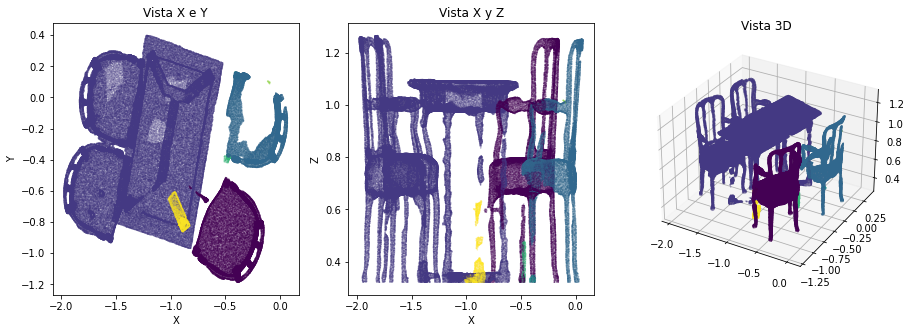

In [56]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
cluster_db = DBSCAN( eps=0.05).fit(X)
clase_pred=cluster_db.labels_
graficar(x[mascara],y[mascara],z[mascara], clase_pred)
print("Cantidad de Cluster: ")
print(len(set(cluster_db.labels_)) - (1 if -1 in cluster_db.labels_ else 0))

Cantidad de Cluster: 
2


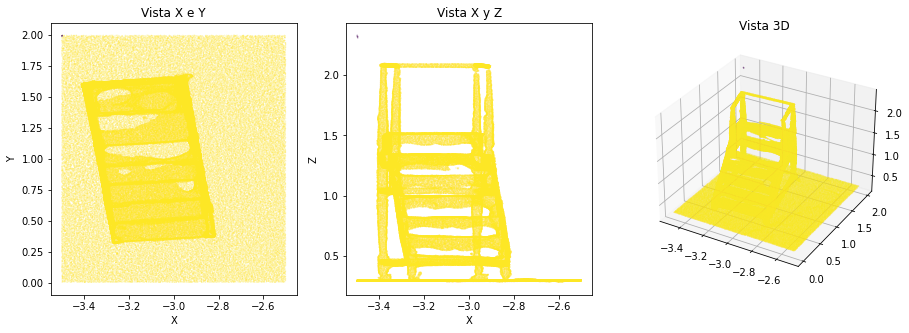

In [57]:
X=np.column_stack((x[mascara_escalera], y[mascara_escalera], z[mascara_escalera]))
cluster_db = DBSCAN(eps=0.10).fit(X)
clase_pred=cluster_db.labels_
graficar(x[mascara_escalera],y[mascara_escalera],z[mascara_escalera], clase_pred)
print("Cantidad de Cluster: ")
print(len(set(cluster_db.labels_)) - (1 if -1 in cluster_db.labels_ else 0))



Cantidad de Cluster: 
15


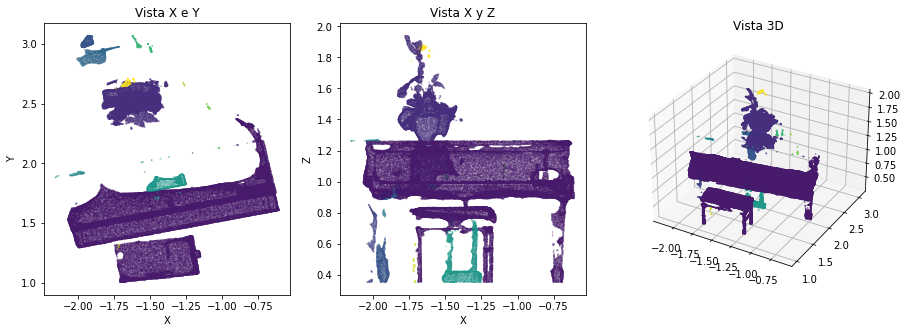

In [58]:
X=np.column_stack((x[mascara_maceta], y[mascara_maceta], z[mascara_maceta]))
cluster_db = DBSCAN(eps=0.10).fit(X)
clase_pred=cluster_db.labels_
graficar(x[mascara_maceta],y[mascara_maceta],z[mascara_maceta], clase_pred)
print("Cantidad de Cluster: ")
print(len(set(cluster_db.labels_)) - (1 if -1 in cluster_db.labels_ else 0))

Cantidad de Cluster: 
15


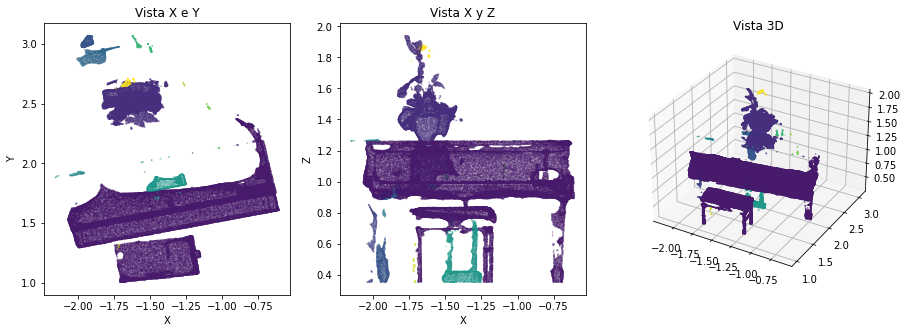

In [62]:
X=np.column_stack((x[mascara_maceta], y[mascara_maceta], z[mascara_maceta]))
cluster_db = DBSCAN(eps=0.10).fit(X)
clase_pred=cluster_db.labels_
graficar(x[mascara_maceta],y[mascara_maceta],z[mascara_maceta], clase_pred)
print("Cantidad de Cluster: ")
print(len(set(cluster_db.labels_)) - (1 if -1 in cluster_db.labels_ else 0))

## Meanshift

Se evaluan los dataset con Meanshift, en este caso, se estima el ancho de banda con un quantile de 0.2

In [60]:
from sklearn.cluster import MeanShift, estimate_bandwidth

Cantidad de Clúster: 2


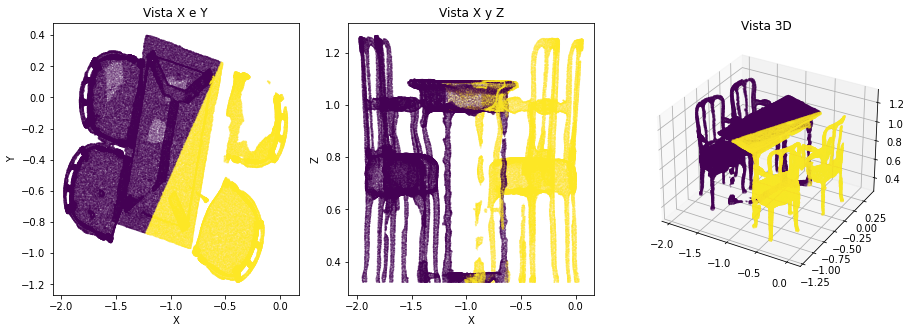

In [61]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

clase_pred=ms.labels_
graficar(x[mascara],y[mascara],z[mascara], clase_pred)
print("Cantidad de Clúster: %d" % n_clusters_)


Cantidad de Clúster: 3


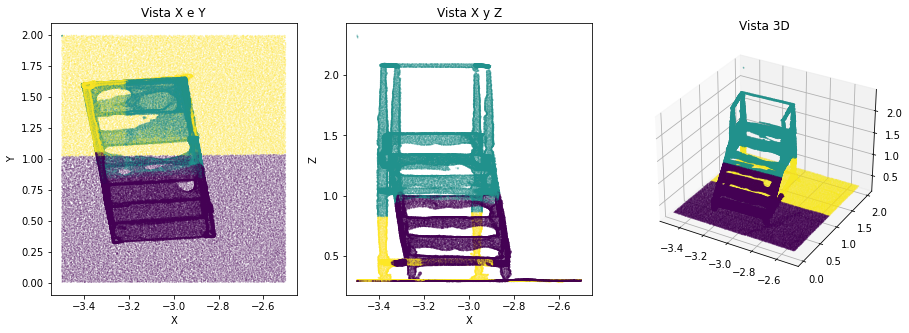

In [63]:
X=np.column_stack((x[mascara_escalera], y[mascara_escalera], z[mascara_escalera]))

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

clase_pred=ms.labels_
graficar(x[mascara_escalera],y[mascara_escalera],z[mascara_escalera], clase_pred)
print("Cantidad de Clúster: %d" % n_clusters_)


## Optics

Se evalua con optics, es un algortimo similar a DB-SCAN pero utiliza menos memoria. Sólo se evalua el dataset de la mesa, ya que demora mucho tiempo en ejecutarse.

In [64]:
from sklearn.cluster import OPTICS

In [65]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
cluster_op = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05).fit(X)
# graficar(x[mascara],y[mascara],z[mascara], cluster_op)

print("Cantidad de Cluster: ")
print(len(set(cluster_op.labels_)) - (1 if -1 in cluster_op.labels_ else 0))

Cantidad de Cluster: 
4


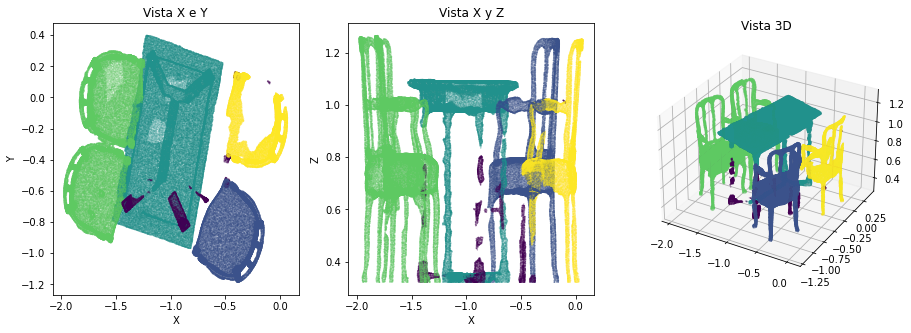

In [66]:
graficar(x[mascara],y[mascara],z[mascara], cluster_op.labels_)

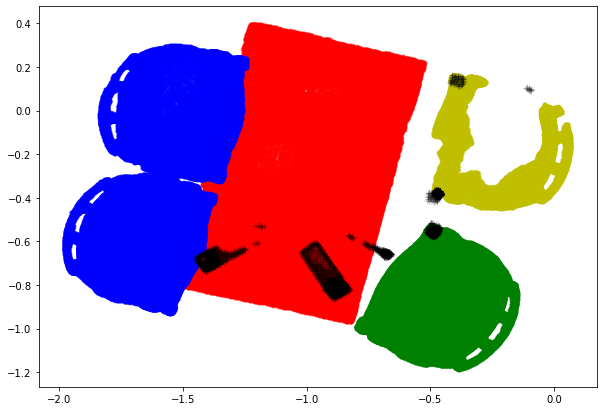

In [67]:
import matplotlib.gridspec as gridspec

space = np.arange(len(X))
reachability = cluster_op.reachability_[cluster_op.ordering_]
labels = cluster_op.labels_[cluster_op.ordering_]

plt.figure(figsize=(10, 7))

colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[cluster_op.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(X[cluster_op.labels_ == -1, 0], X[cluster_op.labels_ == -1, 1], "k+", alpha=0.1)

plt.show()

## Birch

Se evalua con Birch.

In [68]:
from sklearn.cluster import Birch

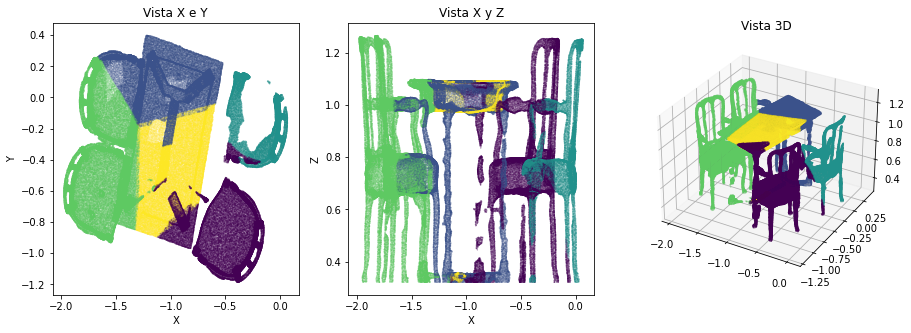

In [69]:
X=np.column_stack((x[mascara], y[mascara], z[mascara]))
clustering_birch = Birch(n_clusters=5)
clustering_birch.fit(X)
clase_pred=clustering_birch.labels_
graficar(x[mascara],y[mascara],z[mascara], clase_pred)


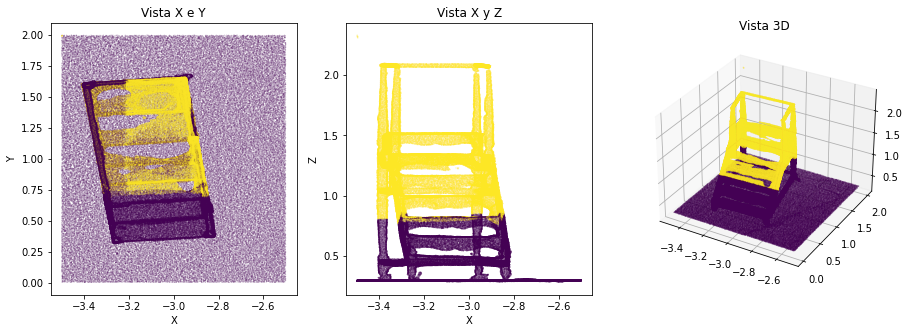

In [70]:
X=np.column_stack((x[mascara_escalera], y[mascara_escalera], z[mascara_escalera]))
clustering_birch = Birch(n_clusters=2)
clustering_birch.fit(X)
clase_pred=clustering_birch.labels_
graficar(x[mascara_escalera],y[mascara_escalera],z[mascara_escalera], clase_pred)